In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime

In [2]:
!dir

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 04A9-8968

 C:\Users\나\Desktop\업무\Data Analysis 디렉터리

2020-12-09  오후 10:10    <DIR>          .
2020-12-09  오후 10:10    <DIR>          ..
2020-12-03  오후 03:18    <DIR>          .ipynb_checkpoints
2020-09-26  오전 05:40     3,248,970,693 AL_11_D151_20200925.csv
2020-12-07  오후 03:32           882,655 coor_df.csv
2020-11-21  오후 07:52               315 debug.log
2020-12-03  오후 03:45           245,179 EDA.ipynb
2020-11-24  오후 03:05        87,232,378 entrc_seoul.txt
2020-12-09  오후 10:10           432,618 Feature Engineering.ipynb
2020-12-04  오후 04:45         5,050,450 get_coor.csv
2020-12-07  오후 12:52               115 juso_api.txt
2020-12-04  오후 05:45                43 kakao_api.txt
2020-12-02  오후 05:00           348,527 Practice.ipynb
2020-12-02  오전 10:56           432,892 서울_오피스텔_2020_01_01_2020_10_31.ipynb
2020-12-02  오후 02:43    <DIR>          서울시 부동산 실거래가 정보
2020-12-03  오전 11:02    <DIR>          오피스텔 실거래가
2020-11-21  오후 12:52           664,632 오피스텔(매매)_

## Read Data

In [3]:
def land_number_allocator(x):
    try:
        return str(int(x))
    except:
        return x

In [4]:
def full_address_allocator(df):
    
    df['전체주소'] = '서울특별시' + ' ' + df['자치구명'] + ' ' + df['법정동명'] + ' '\
                    + df['지번코드'].apply(str).str[-8:-4].apply(land_number_allocator) + '-'\
                    + df['지번코드'].apply(str).str[-4:].apply(land_number_allocator)
    
    
    simple_cols = ['전체주소', '신고년도', '건물면적', '층정보', '물건금액', '건축년도', '건물주용도']
    
    return df[simple_cols].dropna().drop_duplicates()

In [5]:
def create_officetel_prices_df():
    basedir = './서울시 부동산 실거래가 정보/'
    filenames = os.listdir(basedir)
    
    dfs_list = []
    
    for filename in tqdm(filenames, position=0):
        if filename.endswith('.csv'):
            try:
                df = pd.read_csv(basedir + filename, low_memory=False)
            except:
                df = pd.read_csv(basedir + filename, encoding='euc-kr', low_memory=False)
            #officetel_df = df[df['건물주용도'] == '오피스텔']
            #officetel_df['물건금액'] = officetel_df['물건금액']
            
            dfs_list.append(full_address_allocator(df))
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    concat_df['층정보'] = concat_df['층정보'].astype(int)
    concat_df['건축년도'] = concat_df['건축년도'].astype(int)
    #concat_df['대지권비율'] = concat_df['건물면적'] / concat_df['대지권면적']
    
    '''concat_df = concat_df[(concat_df['대지권비율'] < concat_df['대지권비율'].quantile(0.995)) & \
                          (concat_df['대지권비율'] > concat_df['대지권비율'].quantile(0.005))]'''
    
    concat_df['건물나이'] = concat_df['신고년도'] - concat_df['건축년도']
    
    #simple_cols = ['전체주소', '신고년도', '건물면적', '층정보', '물건금액', '건축년도', '건물주용도']
    concat_df.columns = ['전체주소', '년', '전용면적(㎡)', '층', '가격', '건축년도', '건물종류', '건물나이']
    
    concat_df['아파트'] = 0
    concat_df['연립주택'] = 0
    concat_df['오피스텔'] = 0
    
    concat_df['아파트'] = concat_df['건물종류'].apply(lambda x: 1 if x == '아파트' else 0)
    concat_df['연립주택'] = concat_df['건물종류'].apply(lambda x: 1 if x == '연립주택' else 0)
    concat_df['오피스텔'] = concat_df['건물종류'].apply(lambda x: 1 if x == '오피스텔' else 0)
    
    simple_cols = ['전체주소', '년', '전용면적(㎡)', '층', '가격', '건축년도', '건물나이', '아파트', '연립주택', '오피스텔']
    
    return concat_df[simple_cols]

In [6]:
%%time
main_data_df = create_officetel_prices_df()
main_data_df.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.06s/it]


Wall time: 19 s


(1907507, 10)

In [7]:
main_data_df.head()

,전체주소,년,전용면적(㎡),층,가격,건축년도,건물나이,아파트,연립주택,오피스텔
0,서울특별시 양천구 신정동 339-0,2006,59.83,4,215000000,2001,5,1,0,0
1,서울특별시 강동구 천호동 214-60,2006,50.25,1,135000000,1990,16,0,1,0
2,서울특별시 양천구 목동 709-2,2006,77.17,14,273000000,2000,6,1,0,0
3,서울특별시 강동구 길동 160-0,2006,111.51,2,425000000,1983,23,1,0,0
4,서울특별시 양천구 신정동 314-0,2006,71.77,10,630000000,1987,19,1,0,0


In [8]:
main_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1907507 entries, 0 to 1907506
Data columns (total 10 columns):
 #   Column   Dtype  
---  ------   -----  
 0   전체주소     object 
 1   년        int64  
 2   전용면적(㎡)  float64
 3   층        int32  
 4   가격       int64  
 5   건축년도     int32  
 6   건물나이     int64  
 7   아파트      int64  
 8   연립주택     int64  
 9   오피스텔     int64  
dtypes: float64(1), int32(2), int64(6), object(1)
memory usage: 131.0+ MB


In [13]:
main_target_df = pd.DataFrame({'전체주소': '서울특별시 구로구 구로동 481-6', '년': 2020, '전용면적(㎡)': 1257.25,
                               '층': 2, '건축년도': 2020, '건물나이': 0, '아파트': 0, '연립주택': 1, '오피스텔': 0}, index=[0])
main_target_df.shape

(1, 9)

In [14]:
main_target_df

,전체주소,년,전용면적(㎡),층,건축년도,건물나이,아파트,연립주택,오피스텔
0,서울특별시 구로구 구로동 481-6,2020,1257.25,2,2020,0,0,1,0


In [15]:
def bon_bun_allocator(x):
    splitted = x.split('-')
    return int(splitted[0])

def bu_bun_allocator(x):
    splitted = x.split('-')
    if len(splitted) == 2:
        return int(splitted[1])
    elif len(splitted) == 1:
        return 0
    else:
        print('error')
        return

In [16]:
def create_land_prices_():
    df = pd.read_csv('AL_11_D151_20200925.csv', encoding='euc-kr', usecols=[2,5,6,8])
    
    since_2006_df = df[df['기준년도'] >= 2006]
    
    simple_cols = ['법정동명', '지번', '기준년도', '공시지가']
    
    bonbun = df['지번'].apply(bon_bun_allocator)
    bubun = df['지번'].apply(bu_bun_allocator)
    df['전체주소'] = df['법정동명'] + ' ' + bonbun.apply(str) + '-' + bubun.apply(str)
    
    df = df[['전체주소', '기준년도', '공시지가']]
    
    df['공시지가'] = df['공시지가'] / 10000
    
    df.columns = ['전체주소', '년', '공시지가(만원)']
    
    return df

In [17]:
%%time
land_prices_df = create_land_prices_()
land_prices_df.shape

Wall time: 5min 29s


(29393777, 3)

In [18]:
land_prices_df.head()

,전체주소,년,공시지가(만원)
0,서울특별시 종로구 청운동 1-0,1990,75.0
1,서울특별시 종로구 청운동 1-0,1991,98.0
2,서울특별시 종로구 청운동 1-0,1992,98.0
3,서울특별시 종로구 청운동 1-0,1993,98.0
4,서울특별시 종로구 청운동 1-0,1994,96.0


In [19]:
land_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29393777 entries, 0 to 29393776
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   전체주소      object 
 1   년         int64  
 2   공시지가(만원)  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 672.8+ MB


In [14]:
def create_secondary_officetel_prices_df():
    basedir = './오피스텔 실거래가/'
    filenames = os.listdir(basedir)
    
    dfs_list = []
    
    for filename in tqdm(filenames, position=0):
        if filename.endswith('.xlsx'):
            df = pd.read_excel(basedir + filename, header=16).drop_duplicates()
            
            df['전체주소'] = df['시군구'] + ' ' + df['번지']
            
            df['신고년도'] = df['계약년월'].apply(str).str[:4]
            df['월'] = df['계약년월'].apply(str).str[4:]
            
            df['거래금액(만원)'] = df['거래금액(만원)'].str.replace(',', '').apply(float)
            
            
            simple_cols = ['전체주소', '전용면적(㎡)', '신고년도', '월', '거래금액(만원)', '층']
            
            dfs_list.append(df[simple_cols].dropna())
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    concat_df['신고년도'] = concat_df['신고년도'].astype(int)
    
    concat_df.columns = ['전체주소', '전용면적(㎡)', '년', '월', '가격(만원)', '층']
      
    return concat_df

In [15]:
secondary_officetel_prices_df = create_secondary_officetel_prices_df()
secondary_officetel_prices_df.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.03s/it]


(162977, 6)

In [16]:
secondary_officetel_prices_df.head()

,전체주소,전용면적(㎡),년,월,가격(만원),층
0,서울특별시 강남구 개포동 13-3,32.44,2006,01,6400.0,8
1,서울특별시 강남구 개포동 13-3,32.44,2006,01,7100.0,7
2,서울특별시 강남구 개포동 13-3,32.44,2006,01,7300.0,11
3,서울특별시 강남구 개포동 13-3,31.91,2006,01,7500.0,10
4,서울특별시 강남구 개포동 13-3,32.44,2006,01,7400.0,15


In [17]:
secondary_officetel_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162977 entries, 0 to 162976
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   전체주소     162977 non-null  object 
 1   전용면적(㎡)  162977 non-null  float64
 2   년        162977 non-null  int32  
 3   월        162977 non-null  object 
 4   가격(만원)   162977 non-null  float64
 5   층        162977 non-null  int64  
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 6.8+ MB


In [20]:
def land_plans_full_address_allocator(df):
    bonbun = df['지번'].apply(bon_bun_allocator)
    bubun = df['지번'].apply(bu_bun_allocator)
    
    df['전체주소'] = df['법정동명'] + ' ' + bonbun.apply(str) + '-' + bubun.apply(str)
    
    simple_cols = ['전체주소', '용도지역지구명']
    df = df[simple_cols]
    
    return df.dropna().drop_duplicates()

In [21]:
def land_plan_unstack(df):
    
    df['이진항'] = 1
    df = df.set_index(['전체주소', '용도지역지구명'])
    df = df.unstack(-1, 0).reset_index()
    
    cols = df.columns
    new_cols = []
    for i in range(len(cols)):
        if i == 0:
            new_cols.append(cols[i][0])
        else:
            new_cols.append(cols[i][1])
    
    df.columns = new_cols
    
    return df

In [604]:
basedir = './토지이용계획정보/'
prac_df = pd.read_csv(basedir + 'AL_11_D155_20201107.csv', encoding='euc-kr', low_memory=False).drop_duplicates()

In [606]:
prac_df.shape

(8455920, 13)

In [607]:
prac_df.head()

,고유번호,법정동코드,법정동명,대장구분코드,대장구분명,지번,도면번호,저촉여부코드,저촉여부,용도지역지구코드,용도지역지구명,등록일자,데이터기준일자
0,1111010100100010000,1111010100,서울특별시 종로구 청운동,1,토지대장,1,12900001111020080001UNE2010001001,1,포함,UNE201,대공방어협조구역(위탁고도:54-236m),2009-12-29,2020-06-09
1,1111010100100010000,1111010100,서울특별시 종로구 청운동,1,토지대장,1,13404001111020080001UOA1200010002,2,저촉,UOA120,상대보호구역,2009-12-28,2020-06-09
2,1111010100100010000,1111010100,서울특별시 종로구 청운동,1,토지대장,1,15000001111020000000UQA01X0000001,1,포함,UQA01X,도시지역,2009-12-28,2020-06-09
3,1111010100100010000,1111010100,서울특별시 종로구 청운동,1,토지대장,1,15000001111020000000UQF1100071000,2,저촉,UQF110,자연경관지구,2009-12-28,2020-06-09
4,1111010100100010000,1111010100,서울특별시 종로구 청운동,1,토지대장,1,15000001111020000000UQS1000507000,2,저촉,UQS100,도로,2009-12-28,2020-06-09


In [613]:
prac_df['용도지역지구명'].nunique()

329

In [608]:
prac_df['저촉여부'].value_counts()

포함    7056171
접함     792408
저촉     607341
Name: 저촉여부, dtype: int64

In [609]:
samjong_df = prac_df[prac_df['용도지역지구명'].str.contains('3종')]
samjong_df.shape

(189921, 13)

In [610]:
samjong_df.head()

,고유번호,법정동코드,법정동명,대장구분코드,대장구분명,지번,도면번호,저촉여부코드,저촉여부,용도지역지구코드,용도지역지구명,등록일자,데이터기준일자
28716,1111010600100730001,1111010600,서울특별시 종로구 통의동,1,토지대장,73-1,15000001111020030022UQA1230001001,2,저촉,UQA123,제3종일반주거지역,2020-04-23,2020-06-09
29463,1111010600101260001,1111010600,서울특별시 종로구 통의동,1,토지대장,126-1,15000001111020030022UQA1230001001,2,저촉,UQA123,제3종일반주거지역,2009-12-28,2020-06-09
29474,1111010600101390000,1111010600,서울특별시 종로구 통의동,1,토지대장,139,15000001111020030022UQA1230001001,2,저촉,UQA123,제3종일반주거지역,2018-10-01,2020-06-09
29487,1111010600101400002,1111010600,서울특별시 종로구 통의동,1,토지대장,140-2,15000001111020030022UQA1230001001,1,포함,UQA123,제3종일반주거지역,2009-12-28,2020-06-09
29608,1111010700100080006,1111010700,서울특별시 종로구 적선동,1,토지대장,8-6,15000001111020030022UQA1230001001,2,저촉,UQA123,제3종일반주거지역,2014-04-09,2020-06-09


In [611]:
samjong_df['저촉여부'].value_counts()

포함    135248
접함     34725
저촉     19948
Name: 저촉여부, dtype: int64

In [22]:
def create_land_plans_df():
    basedir = './토지이용계획정보/'
    df = pd.read_csv(basedir + 'AL_11_D155_20201107.csv', encoding='euc-kr', low_memory=False).drop_duplicates()
    
    df = land_plans_full_address_allocator(df)
    
    df = land_plan_unstack(df)
    
    return df

In [23]:
%%time
land_plans_df = create_land_plans_df()
land_plans_df.shape

Wall time: 1min 35s


(933503, 330)

In [24]:
land_plans_df.head()

,전체주소,(한강)오염행위 제한지역,(한강)폐기물매립시설 설치제한지역,가로구역별 최고높이 제한지역,가스공급설비,가스공급시설,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가·착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고가도로,고도지구,고등학교,고속철도,고압선,공간시설미분류,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공시설용지,공공주택지구,공공지원민간임대주택 공급촉진지구,공공청사,공동구,공설화장시설,공원,공원마을지구(공원집단시설지구),공원문화유산지구,공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항,공항소음피해예상지역,공항소음피해지역,과밀억제권역,광로1류(폭 70M 이상),광로2류(폭 50M~70M),광로3류(폭 40M~50M),광역계획구역,광역복합환승센터,광장,교육환경보호구역,교차점광장,교통광장,교통운수시설미분류,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,군사기지 및 군사시설 보호구역,궤도,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타도시방재시설,기타문화시설,기타방송통신시설,기타보건위생시설,기타사회복지시설,기타수도시설,기타시장시설,기타열공급설비,기타용도지역지구기타,기타용도지역지구미분류,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타전기공급설비,기타주차장시설,기타철도시설,기타폐기물처리시설,기타하수도시설,기타학교시설,기타환경기초시설,노외주차장,녹지,농수산물공판장및농수산물종합유통센터,대공방어협조구역,대공방어협조구역(위탁고도:54-236m),대공방어협조구역(위탁고도:77-257m),대로1류(폭 35M~40M),대로2류(폭 30M~35M),대로3류(폭 25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획 입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,등록문화재구역,묘지공원,문화공원,문화시설,문화재,문화재보존영향 검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방화지구,배수시설,변전소(전원개발사업구역),변전시설,보건위생시설미분류,보전녹지지역,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제1구역(전술),비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(전술),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사회복지시설,산업개발진흥지구,산업기술단지,산업시설구역,상대보호구역,상수원보호구역,생산녹지지역,생태·경관보전지역,생태·경관완충보전구역,생태·경관핵심보전구역,소공원,소로1류(폭 10M~12M),소로2류(폭 8M~10M),소로3류(폭 8M 미만),소하천,소하천구역,소하천예정지,수도공급시설,수질오염방지시설,수평표면구역,시·도 생태·경관보전지역,시·도야생생물보호구역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,시험림구역,아파트지구,액화석유가스충전시설,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,온천원보호지구,완충녹지,용도구역기타,용도구역미분류,용도지구취락지구,운동장,원추표면구역,원형보존지,유류저장및송유설비,유수시설,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반광장,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차운전학원,자동차전용도로,자동차정류장,자연경관지구,자연공원용도지구기타,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,재해위험지구기타,재활용시설,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종 구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(방공기지 : 1km),제한보호구역(전술항공:5km),제한보호구역(후방지역:500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주간선도로,주거용지,주거환경개선지구,주요시설광장,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭 20M~25M),중로2류(폭 15M~20M),중로3류(폭 12M~15M),중심대광장,중심상업지역,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,집산도로,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,취수시설,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,토지형질변경규제지역,통제보호구역,통제보호구역(민통선이남:300m),통제보호구역(방공기지:500m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,하수도,하수종말처리시설,하천,하천구역,하천미분류,학교,학교이적지,현상변경허가 대상구역,홍수관리구역,환경정비구역
0,서울특별시 강남구 개포동 1-0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,서울특별시 강남구 개포동 100-0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

In [25]:
land_plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933503 entries, 0 to 933502
Columns: 330 entries, 전체주소 to 환경정비구역
dtypes: int64(329), object(1)
memory usage: 2.3+ GB


In [9]:
main_data_df['전체주소'].nunique()

88771

In [10]:
main_data_df['전체주소'].nunique() / 10

8877.1

In [11]:
np.ceil(main_data_df['전체주소'].nunique() / 10)

8878.0

In [65]:
def fetch_coor_data(df):
    unique_addresses = df['전체주소'].unique()
    roadname_url = 'https://www.juso.go.kr/addrlink/addrLinkApi.do?'
    roadname_apikey = 'devU01TX0FVVEgyMDIwMTIwNzEyNTE1OTExMDUxMTk='
    coor_base_url = 'https://www.juso.go.kr/addrlink/addrCoordApi.do?'
    coor_apikey = 'devU01TX0FVVEgyMDIwMTIwNDE3NDIyNDExMDUwNTc='
    #apikey 만료시 https://www.juso.go.kr/addrlink/devAddrLinkRequestWrite.do?returnFn=write&cntcMenu=URL 가서 새로 받을 것.
    
    addr_list = []
    coor_x_list = []
    coor_y_list = []
    
    count = 0
    
    for address in tqdm(unique_addresses, position=0):        
        try:
            roadname_result = requests.get(roadname_url + 'confmKey=' + roadname_apikey + '&currentPage=1' + '&countPerPage=1' + '&keyword=' \
                                           + address + '&resultType=json' + '&hstryYn=Y')
            roadname_info = roadname_result.json()['results']['juso'][0]

            coor_result = requests.get(coor_base_url + 'confmKey=' + coor_apikey + '&admCd=' + roadname_info['admCd'] + '&rnMgtSn='\
                                       + roadname_info['rnMgtSn'] + '&udrtYn=' + roadname_info['udrtYn'] + '&buldMnnm='\
                                       + roadname_info['buldMnnm'] + '&buldSlno=' + roadname_info['buldSlno'] +'&resultType=json')
            coor_info = coor_result.json()['results']['juso'][0]

            coor_x = pd.to_numeric(coor_info['entX'])
            coor_y = pd.to_numeric(coor_info['entY'])

            addr_list.append(address)
            coor_x_list.append(coor_x)
            coor_y_list.append(coor_y)
        except:
            if address.endswith('-1'):
                pass
            else:
                try:
                    address = address.replace('-0', '')
                    
                    roadname_result = requests.get(roadname_url + 'confmKey=' + roadname_apikey + '&currentPage=1' + '&countPerPage=1' 
                                                   + '&keyword=' + address + '&resultType=json' + '&hstryYn=Y')
                    roadname_info = roadname_result.json()['results']['juso'][0]

                    coor_result = requests.get(coor_base_url + 'confmKey=' + coor_apikey + '&admCd=' + roadname_info['admCd'] + '&rnMgtSn='\
                                               + roadname_info['rnMgtSn'] + '&udrtYn=' + roadname_info['udrtYn'] + '&buldMnnm='\
                                               + roadname_info['buldMnnm'] + '&buldSlno=' + roadname_info['buldSlno'] +'&resultType=json')
                    coor_info = coor_result.json()['results']['juso'][0]

                    coor_x = pd.to_numeric(coor_info['entX'])
                    coor_y = pd.to_numeric(coor_info['entY'])

                    addr_list.append(address)
                    coor_x_list.append(coor_x)
                    coor_y_list.append(coor_y)

                except:
                    pass
            
        
        count += 1
        
        if (count % np.floor(len(unique_addresses)/10)) == 0:
            coor_dict = {'전체주소': addr_list, 'x좌표': coor_x_list, 'y좌표': coor_y_list}
            coor_df = pd.DataFrame(coor_dict)
            coor_df.to_csv('original_coordinates_data{}.csv'.format(datetime.datetime.now()))
            
            
        
    coor_dict = {'전체주소': addr_list, 'x좌표': coor_x_list, 'y좌표': coor_y_list}
    
    coor_df = pd.DataFrame(coor_dict)
    
    return coor_df

In [16]:
%%time
fetch_coor_data(main_data_df)

100%|██████████████████████████████████████████████████████████████████████████| 88771/88771 [7:18:29<00:00,  3.37it/s]

Wall time: 7h 18min 30s


In [120]:
def add_0(x):
    splitted = x.split('-')
    if len(splitted) == 1:
        return x+'-0'
    else:
        return x

In [121]:
def read_coor_data():
    basedir = './좌표데이터3/'
    filenames = os.listdir(basedir)
    
    dfs_list = []
    
    for filename in tqdm(filenames, position=0):
        if filename.endswith('.csv'):
            df = pd.read_csv(basedir + filename)
            dfs_list.append(df)
            
    concat_df = pd.concat(dfs_list)
    
    concat_df = concat_df[['전체주소', 'x좌표', 'y좌표']]
    
    concat_df['전체주소'] = concat_df['전체주소'].apply(add_0)
    
    return concat_df

In [122]:
original_coor_df = read_coor_data()

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 111.41it/s]


In [123]:
original_coor_df.shape

(84349, 3)

In [124]:
original_coor_df.head()

,전체주소,x좌표,y좌표
0,서울특별시 양천구 신정동 339-0,944806.276643,1.947001e+06
1,서울특별시 강동구 길동 160-0,968954.010468,1.949060e+06
2,서울특별시 양천구 신정동 314-0,944212.602398,1.947199e+06
3,서울특별시 강동구 고덕동 212-0,970202.844451,1.950847e+06
4,서울특별시 양천구 신정동 329-0,944259.661105,1.946646e+06


In [125]:
unique_addresses = main_data_df['전체주소'].unique()
len(unique_addresses)

88771

In [126]:
addr_no_coor = pd.DataFrame({'전체주소': unique_addresses})
addr_no_coor.shape

(88771, 1)

In [127]:
addr_no_coor = addr_no_coor[addr_no_coor['전체주소'].isin(original_coor_df['전체주소']) == False]
addr_no_coor.shape

(4422, 1)

In [128]:
addr_no_coor.head(20)

,전체주소
12,서울특별시 강동구 둔촌동 174-1
36,서울특별시 강동구 고덕동 492-0
119,서울특별시 강동구 둔촌동 170-1
273,서울특별시 강동구 성내동 529-3
277,서울특별시 강동구 상일동 152-0
320,서울특별시 강동구 암사동 514-56
475,서울특별시 강동구 암사동 514-67
650,서울특별시 강동구 둔촌동 85-2
797,서울특별시 양천구 목동 765-6
852,서울특별시 강동구 성내동 81-4


In [129]:
original_coor_df.to_csv('original_coor_data_df.csv')

In [41]:
fetch_coor_data(addr_to_download)

100%|██████████████████████████████████████████████████████████████████████████| 46465/46465 [5:50:30<00:00,  2.21it/s]


In [58]:
fetch_coor_data(addr_no_coor)

100%|██████████████████████████████████████████████████████████████████████████| 15155/15155 [2:17:06<00:00,  1.84it/s]


In [274]:
original_coor_df['x좌표'].median()

951489.8566332166

In [275]:
original_coor_df['y좌표'].median()

1948900.6749279741

In [204]:
prac_df = original_coor_df.copy()

In [205]:
prac_df['x_norm'] = prac_df['x좌표'] - prac_df['x좌표'].median()
prac_df['y_norm'] = prac_df['y좌표'] - prac_df['y좌표'].median()

In [206]:
prac_df['x_norm'].describe()

count     2119.000000
mean      1842.674192
std       7755.838697
min     -12709.166944
25%      -4293.503679
50%          0.000000
75%       8232.177252
max      19748.591282
Name: x_norm, dtype: float64

<AxesSubplot:>

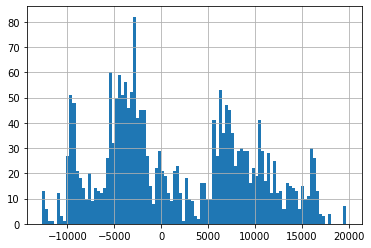

In [208]:
prac_df['x_norm'].hist(bins=100)

In [212]:
prac_df['y_norm'].describe()

count     2119.000000
mean       348.700222
std       5136.491358
min     -10603.939764
25%      -3954.187060
50%          0.000000
75%       3450.644858
max      16028.717759
Name: y_norm, dtype: float64

<AxesSubplot:>

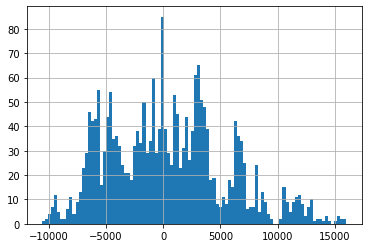

In [213]:
prac_df['y_norm'].hist(bins=100)

In [214]:
prac_df['y_norm_std'] = prac_df['y_norm'] / prac_df['y_norm'].std()

In [215]:
prac_df['y_norm_std'].describe()

count    2119.000000
mean        0.067887
std         1.000000
min        -2.064433
25%        -0.769823
50%         0.000000
75%         0.671790
max         3.120558
Name: y_norm_std, dtype: float64

<AxesSubplot:>

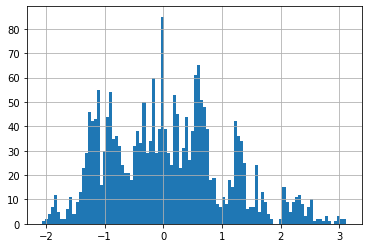

In [216]:
prac_df['y_norm_std'].hist(bins=100)

In [695]:
def coordinates_feature_engineering(df):
    x_med = 951489.8566332166 # 가장 처음 조사했던 x 좌표 자료의 중간값(median).
    y_med = 1948900.6749279741 # 가장 처음 조사했던 y 좌표 자료의 중간값(median).
    x_std = 7755.838697 # 가장 처음 조사했던 x 좌표 자료의 표준편차.
    y_std = 5136.491358 # 가장 처음 조사했던 y 좌표 자료의 표준편차.
    
    df['x_norm'] = (df['x좌표'] - x_med) /1000 #/ x_std
    df['xdegree2'] = df['x_norm']**2 / 2
    df['xdegree3'] = df['x_norm']**3 / 6
    df['xdegree4'] = df['x_norm']**4 / math.factorial(4)
    df['xdegree5'] = df['x_norm']**5 / math.factorial(5)
    df['xdegree6'] = df['x_norm']**6 / math.factorial(6)
    df['xdegree7'] = df['x_norm']**7 / math.factorial(7)
    df['xdegree8'] = df['x_norm']**8 / math.factorial(8)
    df['xdegree9'] = df['x_norm']**9 / math.factorial(9)
    df['xdegree10'] = df['x_norm']**10 / math.factorial(10)
    df['xdegree11'] = df['x_norm']**11 / math.factorial(11)
    df['xdegree12'] = df['x_norm']**12 / math.factorial(12)
    df['xdegree13'] = df['x_norm']**13 / math.factorial(13)
    df['xdegree14'] = df['x_norm']**14 / math.factorial(14)
    df['xdegree15'] = df['x_norm']**15 / math.factorial(15)
    df['xdegree16'] = df['x_norm']**16 / math.factorial(16)
    df['xdegree17'] = df['x_norm']**17 / math.factorial(17)
    df['xdegree18'] = df['x_norm']**18 / math.factorial(18)
    df['xdegree19'] = df['x_norm']**19 / math.factorial(19)
    df['xdegree20'] = df['x_norm']**20 / math.factorial(20)
    df['sin(x_norm)'] = df['x_norm'].apply(math.sin)
    df['cos(x_norm)'] = df['x_norm'].apply(math.cos)
    df['tan(x_norm)'] = df['x_norm'].apply(math.tan)
    
    df['y_norm'] = (df['y좌표'] - y_med) /1000 #/ y_std
    df['ydegree2'] = df['y_norm']**2 / 2
    df['ydegree3'] = df['y_norm']**3 / 6
    df['ydegree4'] = df['y_norm']**4 / math.factorial(4)
    df['ydegree5'] = df['y_norm']**5 / math.factorial(5)
    df['ydegree6'] = df['y_norm']**6 / math.factorial(6)
    df['ydegree7'] = df['y_norm']**7 / math.factorial(7)
    df['ydegree8'] = df['y_norm']**8 / math.factorial(8)
    df['ydegree9'] = df['y_norm']**9 / math.factorial(9)
    df['ydegree10'] = df['y_norm']**10 / math.factorial(10)
    df['ydegree11'] = df['y_norm']**11 / math.factorial(11)
    df['ydegree12'] = df['y_norm']**12 / math.factorial(12)
    df['ydegree13'] = df['y_norm']**13 / math.factorial(13)
    df['ydegree14'] = df['y_norm']**14 / math.factorial(14)
    df['ydegree15'] = df['y_norm']**15 / math.factorial(15)
    df['ydegree16'] = df['y_norm']**16 / math.factorial(16)
    df['ydegree17'] = df['y_norm']**17 / math.factorial(17)
    df['ydegree18'] = df['y_norm']**18 / math.factorial(18)
    df['ydegree19'] = df['y_norm']**19 / math.factorial(19)
    df['ydegree20'] = df['y_norm']**20 / math.factorial(20)
    df['sin(y_norm)'] = df['y_norm'].apply(math.sin)
    df['cos(y_norm)'] = df['y_norm'].apply(math.cos)
    df['tan(y_norm)'] = df['y_norm'].apply(math.tan)
    
    cols = ['전체주소', 'x_norm',
            'xdegree2', 'xdegree3', 'xdegree4', 'xdegree5',
            'xdegree6', 'xdegree7', 'xdegree8', 'xdegree9', 'xdegree10', 
            'xdegree11', 'xdegree12', 'xdegree13', 'xdegree14', 'xdegree15',
            'xdegree16', 'xdegree17', 'xdegree18', 'xdegree19', 'xdegree20',
            'sin(x_norm)', 'cos(x_norm)', 'tan(x_norm)',
            'y_norm',
            'ydegree2', 'ydegree3', 'ydegree4', 'ydegree5',
            'ydegree6', 'ydegree7', 'ydegree8', 'ydegree9', 'ydegree10',
            'ydegree11', 'ydegree12', 'ydegree13', 'ydegree14', 'ydegree15',
            'ydegree16', 'ydegree17', 'ydegree18', 'ydegree19', 'ydegree20',
            'sin(y_norm)', 'cos(y_norm)', 'tan(y_norm)']
    
    return df[cols]

In [696]:
coor_df = coordinates_feature_engineering(original_coor_df)
coor_df.shape

(2119, 47)

In [697]:
coor_df.head()

,전체주소,x_norm,xdegree2,xdegree3,xdegree4,xdegree5,xdegree6,xdegree7,xdegree8,xdegree9,xdegree10,xdegree11,xdegree12,xdegree13,xdegree14,xdegree15,xdegree16,xdegree17,xdegree18,xdegree19,xdegree20,sin(x_norm),cos(x_norm),tan(x_norm),y_norm,ydegree2,ydegree3,ydegree4,ydegree5,ydegree6,ydegree7,ydegree8,ydegree9,ydegree10,ydegree11,ydegree12,ydegree13,ydegree14,ydegree15,ydegree16,ydegree17,ydegree18,ydegree19,ydegree20,sin(y_norm),cos(y_norm),tan(y_norm)
0,서울특별시 강동구 길동 386-8,16.471844,135.660822,744.861302,3067.309791,10104.849679,27740.917934,65277.724677,134405.562230,245989.717152,405190.424758,606748.497151,832855.549576,1.055282e+06,1.241603e+06,1.363433e+06,1.403641e+06,1.360032e+06,1.244569e+06,1.078966e+06,8.886276e+05,-0.691729,-0.722157,0.957865,-0.128306,0.008231,-0.000352,1.129217e-05,-2.897706e-07,6.196553e-09,-1.135793e-10,1.821614e-12,-2.596935e-14,3.332024e-16,-3.886535e-18,4.155549e-20,-4.101400e-22,3.758818e-24,-3.215193e-26,2.578305e-28,-1.945953e-30,1.387098e-32,-9.367001e-35,6.009214e-37,-0.127954,0.991780,-0.129015
1,서울특별시 강동구 천호동 451-20,15.778172,124.475356,654.664530,2582.352395,8148.960070,21429.282323,48302.129026,95264.912712,167011.798019,263514.088190,377979.147137,496985.000931,6.031934e+05,6.798064e+05,7.150735e+05,7.051596e+05,6.544782e+05,5.736927e+05,4.764117e+05,3.758453e+05,-0.070151,-0.997536,0.070324,-0.176888,0.015645,-0.000922,4.079302e-05,-1.443162e-06,4.254644e-08,-1.075139e-09,2.377244e-11,-4.672298e-13,8.264752e-15,-1.329035e-16,1.959090e-18,-2.665694e-20,3.368074e-22,-3.971821e-24,4.391056e-26,-4.568980e-28,4.489997e-30,-4.180149e-32,3.697099e-34,-0.175967,0.984396,-0.178757
2,서울특별시 강동구 길동 413-1,16.588187,137.583966,760.756167,3154.891305,10466.785100,28937.497297,68574.371912,142190.559205,262075.946817,434736.469537,655589.968690,906254.058266,1.156393e+06,1.370176e+06,1.515249e+06,1.570952e+06,1.532897e+06,1.412666e+06,1.233345e+06,1.022948e+06,-0.770881,-0.636979,1.210214,-0.195381,0.019087,-0.001243,6.071765e-05,-2.372611e-06,7.726037e-08,-2.156454e-09,5.266618e-11,-1.143328e-12,2.233842e-14,-3.967723e-16,6.460135e-18,-9.709118e-20,1.354981e-21,-1.764914e-23,2.155188e-25,-2.476953e-27,2.688604e-29,-2.764743e-31,2.700886e-33,-0.194140,0.980974,-0.197905
3,서울특별시 강동구 천호동 161-17,16.156253,130.512248,702.862944,2838.907801,9173.222262,24700.815880,57010.374110,115134.250039,206682.001910,333920.661394,490446.047882,660314.183034,8.206310e+05,9.470229e+05,1.020023e+06,1.029984e+06,9.788637e+05,8.785983e+05,7.470977e+05,6.035150e+05,-0.433424,-0.901190,0.480947,-0.187177,0.017518,-0.001093,5.114494e-05,-1.914636e-06,5.972943e-08,-1.597143e-09,3.736864e-11,-7.771740e-13,1.454694e-14,-2.475327e-16,3.861044e-18,-5.559234e-20,7.432593e-22,-9.274758e-24,1.085016e-25,-1.194650e-27,1.242286e-29,-1.223831e-31,1.145368e-33,-0.186086,0.982533,-0.189394
4,서울특별시 강동구 천호동 414-0,15.556989,121.009952,627.516824,2440.568063,7593.578045,19688.868207,43757.071975,85091.035289,147084.476679,228819.156868,323612.461801,419536.289243,5.020555e+05,5.578908e+05,5.786068e+05,5.625862e+05,5.148322e+05,4.449577e+05,3.643264e+05,2.833911e+05,0.150402,-0.988625,-0.152132,0.062366,0.001945,0.000040,6.303549e-07,7.862565e-09,8.172635e-11,7.281371e-13,5.676391e-15,3.933498e-17,2.453172e-19,1.390863e-21,7.228568e-24,3.467832e-26,1.544824e-28,6.422985e-31,2.503606e-33,9.184726e-36,3.182312e-38,1.044572e-40,3.257297e-43,0.062326,0.998056,0.062447


In [146]:
#coor_df.to_csv('coor_df.csv')
#original_coor_df.to_csv('original_coor_df.csv')

In [24]:
'''def coordinates_full_address_allocator(df):
    df['전체주소'] = df[1] + ' ' + df[2] + ' ' + df[3] + ' ' + df[7].apply(str) + '-' + df[8].apply(str)
    
    simple_cols = ['전체주소', 23, 24]
    
    df = df[simple_cols]
    df.columns = ['전체주소', 'x좌표', 'y좌표']
    
    return df.dropna().drop_duplicates()'''

In [29]:
'''def create_coordinates_df():
    basedir = './좌표데이터/'
    filenames = os.listdir(basedir)
    
    dfs_list = []
    
    for filename in tqdm(filenames, position=0):
        if filename.endswith('.txt'):
            try:
                df = pd.read_csv(basedir + filename, encoding='ansi', sep='|', header=None, usecols=[1,2,3,7,8,23,24])
            except:
                df = pd.read_csv(basedir + filename, sep='|', header=None)
            
            df = coordinates_full_address_allocator(df)
            
            dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    concat_df = coordinates_feature_engineering(concat_df)
    
    return concat_df'''

### Target coordinates

In [463]:
main_target_df

,전체주소,년,대지권면적(㎡),전용면적(㎡),층,대지권비율,건물나이
0,서울특별시 구로구 구로동 481-6,2020,660,1257.25,2,1.904924,0


In [698]:
original_target_coor_df = fetch_coor_data(main_target_df)
original_target_coor_df.shape

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


(1, 3)

In [699]:
original_target_coor_df.head()

,전체주소,x좌표,y좌표
0,서울특별시 구로구 구로동 481-6,945394.775012,1.944373e+06


In [700]:
target_coor_df = coordinates_feature_engineering(original_target_coor_df)
target_coor_df.shape

(1, 47)

In [701]:
target_coor_df.head()

,전체주소,x_norm,xdegree2,xdegree3,xdegree4,xdegree5,xdegree6,xdegree7,xdegree8,xdegree9,xdegree10,xdegree11,xdegree12,xdegree13,xdegree14,xdegree15,xdegree16,xdegree17,xdegree18,xdegree19,xdegree20,sin(x_norm),cos(x_norm),tan(x_norm),y_norm,ydegree2,ydegree3,ydegree4,ydegree5,ydegree6,ydegree7,ydegree8,ydegree9,ydegree10,ydegree11,ydegree12,ydegree13,ydegree14,ydegree15,ydegree16,ydegree17,ydegree18,ydegree19,ydegree20,sin(y_norm),cos(y_norm),tan(y_norm)
0,서울특별시 구로구 구로동 481-6,-6.095082,18.57501,-37.738734,57.505166,-70.099736,71.210602,-62.004919,47.24063,-31.992833,19.499893,-10.804858,5.488041,-2.573081,1.120224,-0.455191,0.173401,-0.06217,0.021052,-0.006753,0.002058,0.186996,0.982361,0.190354,-4.527456,10.248927,-15.467188,17.506752,-15.852208,11.961695,-7.736578,4.378377,-2.202545,0.997192,-0.410431,0.154851,-0.053929,0.01744,-0.005264,0.00149,-0.000397,0.0001,-0.000024,0.000005,0.982949,-0.183881,-5.345568


### Data Joining

In [41]:
print(main_data_df.shape)
print(land_prices_df.shape)
print(secondary_officetel_prices_df.shape)
print(land_plans_df.shape)
print(coor_df.shape)

(140807, 8)
(29393777, 3)
(162977, 6)
(933503, 330)
(2280, 19)


In [44]:
merge_df = main_data_df.merge(land_prices_df, on=['전체주소', '년'])
merge_df.shape

(140183, 9)

In [49]:
merge_df.head()

,전체주소,년,대지권면적(㎡),전용면적(㎡),층,가격(만원),대지권비율,건물나이,공시지가(만원)
0,서울특별시 강동구 길동 386-8,2006,40.68,33.20,2,4200.0,0.816126,16,507.0
1,서울특별시 강동구 길동 386-8,2006,70.19,57.27,8,9000.0,0.815928,16,507.0
2,서울특별시 강동구 길동 386-8,2006,40.68,33.20,4,4100.0,0.816126,16,507.0
3,서울특별시 강동구 길동 386-8,2006,40.68,33.20,7,4600.0,0.816126,16,507.0
4,서울특별시 강동구 길동 386-8,2006,40.68,33.20,10,3950.0,0.816126,16,507.0


In [53]:
'''data3_df = main_data_df.merge(secondary_officetel_prices_df, on=['전체주소', '년', '전용면적(㎡)', '가격(만원)', '층'])
data3_df.shape'''

(107096, 9)

In [54]:
#data3_df.head()

,전체주소,년,대지권면적(㎡),전용면적(㎡),층,가격(만원),대지권비율,건물나이,월
0,서울특별시 강동구 길동 386-8,2006,40.68,33.20,2,4200.0,0.816126,16,05
1,서울특별시 강동구 천호동 451-20,2006,38.74,28.43,12,9250.0,0.733867,3,05
2,서울특별시 강동구 길동 386-8,2006,70.19,57.27,8,9000.0,0.815928,16,05
3,서울특별시 강동구 길동 413-1,2006,46.79,30.65,9,7350.0,0.655054,4,03
4,서울특별시 강동구 천호동 161-17,2006,32.05,23.12,8,5750.0,0.721373,3,04


In [50]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*((x-1)/12))

In [51]:
def month_circular_cosine_func(x):
    return math.cos(2*math.pi*((x-1)/12))

In [54]:
def time_feature_engineering(df):
    df['time_linear'] = df['년'] - df['년'].min() + 1
    #df['month_circular_sine'] = df['월'].apply(float).apply(month_circular_sine_func)
    #df['month_circular_cosine'] = df['월'].apply(float).apply(month_circular_cosine_func)
    
    return df

In [55]:
merge_df = time_feature_engineering(merge_df)
merge_df.shape

(140183, 10)

In [58]:
merge_df = merge_df[['전체주소', 'time_linear', '대지권면적(㎡)', '전용면적(㎡)', '층', '가격(만원)', '대지권비율', '건물나이', '공시지가(만원)']]

In [284]:
merge_df.head()

,전체주소,time_linear,대지권면적(㎡),전용면적(㎡),층,가격(만원),대지권비율,건물나이,공시지가(만원)
0,서울특별시 강동구 길동 386-8,1,40.68,33.20,2,4200.0,0.816126,16,507.0
1,서울특별시 강동구 길동 386-8,1,70.19,57.27,8,9000.0,0.815928,16,507.0
2,서울특별시 강동구 길동 386-8,1,40.68,33.20,4,4100.0,0.816126,16,507.0
3,서울특별시 강동구 길동 386-8,1,40.68,33.20,7,4600.0,0.816126,16,507.0
4,서울특별시 강동구 길동 386-8,1,40.68,33.20,10,3950.0,0.816126,16,507.0


In [702]:
merge2_df = merge_df.merge(coor_df, on='전체주소')
merge2_df.shape

(130916, 55)

In [703]:
merge2_df.head()

,전체주소,time_linear,대지권면적(㎡),전용면적(㎡),층,가격(만원),대지권비율,건물나이,공시지가(만원),x_norm,xdegree2,xdegree3,xdegree4,xdegree5,xdegree6,xdegree7,xdegree8,xdegree9,xdegree10,xdegree11,xdegree12,xdegree13,xdegree14,xdegree15,xdegree16,xdegree17,xdegree18,xdegree19,xdegree20,sin(x_norm),cos(x_norm),tan(x_norm),y_norm,ydegree2,ydegree3,ydegree4,ydegree5,ydegree6,ydegree7,ydegree8,ydegree9,ydegree10,ydegree11,ydegree12,ydegree13,ydegree14,ydegree15,ydegree16,ydegree17,ydegree18,ydegree19,ydegree20,sin(y_norm),cos(y_norm),tan(y_norm)
0,서울특별시 강동구 길동 386-8,1,40.68,33.20,2,4200.0,0.816126,16,507.0,16.471844,135.660822,744.861302,3067.309791,10104.849679,27740.917934,65277.724677,134405.56223,245989.717152,405190.424758,606748.497151,832855.549576,1.055282e+06,1.241603e+06,1.363433e+06,1.403641e+06,1.360032e+06,1.244569e+06,1.078966e+06,888627.597024,-0.691729,-0.722157,0.957865,-0.128306,0.008231,-0.000352,0.000011,-2.897706e-07,6.196553e-09,-1.135793e-10,1.821614e-12,-2.596935e-14,3.332024e-16,-3.886535e-18,4.155549e-20,-4.101400e-22,3.758818e-24,-3.215193e-26,2.578305e-28,-1.945953e-30,1.387098e-32,-9.367001e-35,6.009214e-37,-0.127954,0.99178,-0.129015
1,서울특별시 강동구 길동 386-8,1,70.19,57.27,8,9000.0,0.815928,16,507.0,16.471844,135.660822,744.861302,3067.309791,10104.849679,27740.917934,65277.724677,134405.56223,245989.717152,405190.424758,606748.497151,832855.549576,1.055282e+06,1.241603e+06,1.363433e+06,1.403641e+06,1.360032e+06,1.244569e+06,1.078966e+06,888627.597024,-0.691729,-0.722157,0.957865,-0.128306,0.008231,-0.000352,0.000011,-2.897706e-07,6.196553e-09,-1.135793e-10,1.821614e-12,-2.596935e-14,3.332024e-16,-3.886535e-18,4.155549e-20,-4.101400e-22,3.758818e-24,-3.215193e-26,2.578305e-28,-1.945953e-30,1.387098e-32,-9.367001e-35,6.009214e-37,-0.127954,0.99178,-0.129015
2,서울특별시 강동구 길동 386-8,1,40.68,33.20,4,4100.0,0.816126,16,507.0,16.471844,135.660822,744.861302,3067.309791,10104.849679,27740.917934,65277.724677,134405.56223,245989.717152,405190.424758,606748.497151,832855.549576,1.055282e+06,1.241603e+06,1.363433e+06,1.403641e+06,1.360032e+06,1.244569e+06,1.078966e+06,888627.597024,-0.691729,-0.722157,0.957865,-0.128306,0.008231,-0.000352,0.000011,-2.897706e-07,6.196553e-09,-1.135793e-10,1.821614e-12,-2.596935e-14,3.332024e-16,-3.886535e-18,4.155549e-20,-4.101400e-22,3.758818e-24,-3.215193e-26,2.578305e-28,-1.945953e-30,1.387098e-32,-9.367001e-35,6.009214e-37,-0.127954,0.99178,-0.129015
3,서울특별시 강동구 길동 386-8,1,40.68,33.20,7,4600.0,0.816126,16,507.0,16.471844,135.660822,744.861302,3067.309791,10104.849679,27740.917934,65277.724677,134405.56223,245989.717152,405190.424758,606748.497151,832855.549576,1.055282e+06,1.241603e+06,1.363433e+06,1.403641e+06,1.360032e+06,1.244569e+06,1.078966e+06,888627.597024,-0.691729,-0.722157,0.957865,-0.128306,0.008231,-0.000352,0.000011,-2.897706e-07,6.196553e-09,-1.135793e-10,1.821614e-12,-2.596935e-14,3.332024e-16,-3.886535e-18,4.155549e-20,-4.101400e-22,3.758818e-24,-3.215193e-26,2.578305e-28,-1.945953e-30,1.387098e-32,-9.367001e-35,6.009214e-37,-0.127954,0.99178,-0.129015
4,서울특별시 강동구 길동 386-8,1,40.68,33.20,10,3950.0,0.816126,16,507.0,16.471844,135.660822,744.861302,3067.309791,10104.849679,27740.917934,65277.724677,134405.56223,245989.717152,405190.424758,606748.497151,832855.549576,1.055282e+06,1.241603e+06,1.363433e+06,1.403641e+06,1.360032e+06,1.244569e+06,1.078966e+06,888627.597024,-0.691729,-0.722157,0.957865,-0.128306,0.008231,-0.000352,0.000011,-2.897706e-07,6.196553e-09,-1.135793e-10,1.821614e-12,-2.596935e-14,3.332024e-16,-3.886535e-18,4.155549e-20,-4.101400e-22,3.758818e-24,-3.215193e-26,2.578305e-28,-1.945953e-30,1.387098e-32,-9.367001e-35,6.009214e-37,-0.127954,0.99178,-0.129015


In [704]:
merge3_df = merge2_df.merge(land_plans_df, on='전체주소')
merge3_df.shape

(130916, 384)

In [705]:
description = merge3_df.describe()
cols = merge3_df.columns.tolist()

cols.remove('전체주소')

cols_to_drop = []
for col in cols:
    if description[col]['std'] == 0:
        cols_to_drop.append(col)
        
cols_to_keep = []
for col in merge3_df.columns:
    if col not in cols_to_drop:
        cols_to_keep.append(col)
        
data_df = merge3_df[cols_to_keep]
data_df.shape

(130916, 222)

In [706]:
data_df.head()

,전체주소,time_linear,대지권면적(㎡),전용면적(㎡),층,가격(만원),대지권비율,건물나이,공시지가(만원),x_norm,xdegree2,xdegree3,xdegree4,xdegree5,xdegree6,xdegree7,xdegree8,xdegree9,xdegree10,xdegree11,xdegree12,xdegree13,xdegree14,xdegree15,xdegree16,xdegree17,xdegree18,xdegree19,xdegree20,sin(x_norm),cos(x_norm),tan(x_norm),y_norm,ydegree2,ydegree3,ydegree4,ydegree5,ydegree6,ydegree7,ydegree8,ydegree9,ydegree10,ydegree11,ydegree12,ydegree13,ydegree14,ydegree15,ydegree16,ydegree17,ydegree18,ydegree19,ydegree20,sin(y_norm),cos(y_norm),tan(y_norm),(한강)폐기물매립시설 설치제한지역,가로구역별 최고높이 제한지역,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축허가·착공제한지역,경관녹지,경관지구,고도지구,고속철도,공공공지,공공주택지구,공공청사,공원,공원자연환경지구,공익용산지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,광로1류(폭 70M 이상),광로2류(폭 50M~70M),광로3류(폭 40M~50M),광장,교육환경보호구역,교통광장,국가산업단지,국립공원,국민임대주택단지예정지구,국지도로,국토이용용도지구기타,근린공원,근린상업지역,기타도시공간시설,기타시장시설,기타자동차정류장,기타철도시설,녹지,대공방어협조구역,대공방어협조구역(위탁고도:54-236m),대공방어협조구역(위탁고도:77-257m),대로1류(폭 35M~40M),대로2류(폭 30M~35M),대로3류(폭 25M~30M),도로,도로구역,도시개발구역,도시개발구역기타,도시관리계획 입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시자연공원구역,도시지역,도시철도,문화시설,문화재,문화재보존영향 검토대상구역,문화지구,방송통신시설,방수설비,방화지구,보전산지,보전임지,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사방지,사업지역기타,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,생산녹지지역,소공원,소로1류(폭 10M~12M),소로2류(폭 8M~10M),소로3류(폭 8M 미만),수도공급시설,수평표면구역,시가지경관지구,시장,아파트지구,어린이공원,여객자동차터미널,역사도심,역사문화특화경관지구,온천공보호구역,완충녹지,용도구역기타,원추표면구역,유수지,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반상업지역,일반주거지역,일반철도,자동차검사시설,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,전기공급설비,절대보호구역,정비구역,정비구역기타,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종 구역,제3종일반주거지역,제한보호구역,제한보호구역(전술항공:5km),제한보호구역(후방지역:500m),조망가로미관지구,조망가로특화경관지구,종합의료시설,주거환경개선지구,주차장,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭 20M~25M),중로2류(폭 15M~20M),중로3류(폭 12M~15M),중심상업지역,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,지구단위계획구역,지역특화발전특구,지원시설구역,지하도로,진입표면구역,철도,청소년수련시설,체육시설,침수위험지구,택지개발예정지구,토지거래계약에관한허가구역,특정개발진흥지구,특화경관지구,하수도,하천,하천구역,학교,학교이적지,현상변경허가 대상구역
0,서울특별시 강동구 길동 386-8,1,40.68,33.20,2,4200.0,0.816126,16,507.0,16.471844,135.660822,744.861302,3067.309791,10104.849679,27740.917934,65277.724677,134405.56223,245989.717152,405190.424758,606748.497151,832855.549576,1.055282e+06,1.241603e+06,1.363433e+06,1.403641e+06,1.360032e+06,1.244569e+06,1.078966e+06,888627.597024,-0.691729,-0.722157,0.957865,-0.128306,0.008231,-0.000352,0.000011,-2.897706e-07,6.196553e-09,-1.135793e-10,1.821614e-12,-2.596935e-14,3.332024e-16,-3.886535e-18,4.155549e-20,-4.101400e-22,3.758818e-24,-3.215193e-26,2.578305e-28,-1.945953e-30,1.387098e-32,-9.367001e-35,6.009214e-37,-0.127954,0.99178,-0.129015,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,서울특별시 강동구 길동 386-8,1,70.19,57.27,8,9000.0,0.815928,16,507.0,16.471844,135.660822,744.861302,3067.309791,10104.849679,27740.917934,65277.724677,134405.56223,245989.717152,405190.424758,606748.497151,832855.549576,1.055282e+06,1.241603e+06,1.363433e+06,1.403641e+06,1.360032e+06,1.244569e+06,1.078966e+06,888627.597024,-0.691729,-0.722157,0.957865,-0.128306,0.008231,-0.000352,0.000011,-2.897706e-07,6.196553e-09,-1.135793e-10,1.821614e-12,-2.596935e-14,3.332024e-16,-3.886535e-18,4.155549e-20,-4.101400e-22,3.758818e-24,-3.215193e-26,2.578305e-28,-1.945953e-30,1.387098e-32,-9.367001e-35,6.009214e-37,-0.127954,0.99178,-0.129015,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,서울특별시 강동구 길동 386-8,1,40.68,33.20,4,4100.0,0.816126,16,507.0,16.471844,135.660822,744.861302,3067.309791,10104.84967

### Train, test split

In [589]:
train_sample_df = data_df.sample(frac=0.8)
train_sample_df.shape

(104733, 192)

In [590]:
test_sample_df = data_df.iloc[data_df.index.isin(train_sample_df.index) == False, :]
test_sample_df.shape

(26183, 192)

In [591]:
train_sample_df.shape[0] + test_sample_df.shape[0]

130916

In [592]:
data_df.shape

(130916, 192)

In [593]:
train_cols = [col for col in train_sample_df.columns if col != '전체주소']
len(train_cols)

191

In [594]:
x_cols = [col for col in train_cols if col != '가격(만원)']
x_train = train_sample_df[x_cols]
x_train.shape

(104733, 190)

In [595]:
y_train = train_sample_df['가격(만원)']
y_train.shape

(104733,)

In [596]:
x_test = test_sample_df[x_cols]
x_test.shape

(26183, 190)

In [597]:
y_test = test_sample_df['가격(만원)']
y_test.shape

(26183,)

### main target data joining

In [508]:
main_target_df.shape

(1, 7)

In [509]:
main_target_df.head()

,전체주소,년,대지권면적(㎡),전용면적(㎡),층,대지권비율,건물나이
0,서울특별시 구로구 구로동 481-6,2020,660,1257.25,2,1.904924,0


In [510]:
mt_merge_df = main_target_df.merge(land_prices_df, on=['전체주소', '년'])
mt_merge_df.shape

(1, 8)

In [511]:
mt_merge_df.head()

,전체주소,년,대지권면적(㎡),전용면적(㎡),층,대지권비율,건물나이,공시지가(만원)
0,서울특별시 구로구 구로동 481-6,2020,660,1257.25,2,1.904924,0,502.4


In [512]:
mt_merge_df = time_feature_engineering(mt_merge_df)
mt_merge_df.shape

(1, 9)

In [513]:
mt_merge_df.head()

,전체주소,년,대지권면적(㎡),전용면적(㎡),층,대지권비율,건물나이,공시지가(만원),time_linear
0,서울특별시 구로구 구로동 481-6,2020,660,1257.25,2,1.904924,0,502.4,1


In [707]:
mt_merge2_df = mt_merge_df.merge(target_coor_df, on='전체주소')
mt_merge2_df.shape

(1, 55)

In [708]:
mt_merge2_df.head()

,전체주소,년,대지권면적(㎡),전용면적(㎡),층,대지권비율,건물나이,공시지가(만원),time_linear,x_norm,xdegree2,xdegree3,xdegree4,xdegree5,xdegree6,xdegree7,xdegree8,xdegree9,xdegree10,xdegree11,xdegree12,xdegree13,xdegree14,xdegree15,xdegree16,xdegree17,xdegree18,xdegree19,xdegree20,sin(x_norm),cos(x_norm),tan(x_norm),y_norm,ydegree2,ydegree3,ydegree4,ydegree5,ydegree6,ydegree7,ydegree8,ydegree9,ydegree10,ydegree11,ydegree12,ydegree13,ydegree14,ydegree15,ydegree16,ydegree17,ydegree18,ydegree19,ydegree20,sin(y_norm),cos(y_norm),tan(y_norm)
0,서울특별시 구로구 구로동 481-6,2020,660,1257.25,2,1.904924,0,502.4,1,-6.095082,18.57501,-37.738734,57.505166,-70.099736,71.210602,-62.004919,47.24063,-31.992833,19.499893,-10.804858,5.488041,-2.573081,1.120224,-0.455191,0.173401,-0.06217,0.021052,-0.006753,0.002058,0.186996,0.982361,0.190354,-4.527456,10.248927,-15.467188,17.506752,-15.852208,11.961695,-7.736578,4.378377,-2.202545,0.997192,-0.410431,0.154851,-0.053929,0.01744,-0.005264,0.00149,-0.000397,0.0001,-0.000024,0.000005,0.982949,-0.183881,-5.345568


In [709]:
mt_merge3_df = mt_merge2_df.merge(land_plans_df, on='전체주소')
mt_merge3_df.shape

(1, 384)

In [710]:
mt_merge3_df.head()

,전체주소,년,대지권면적(㎡),전용면적(㎡),층,대지권비율,건물나이,공시지가(만원),time_linear,x_norm,xdegree2,xdegree3,xdegree4,xdegree5,xdegree6,xdegree7,xdegree8,xdegree9,xdegree10,xdegree11,xdegree12,xdegree13,xdegree14,xdegree15,xdegree16,xdegree17,xdegree18,xdegree19,xdegree20,sin(x_norm),cos(x_norm),tan(x_norm),y_norm,ydegree2,ydegree3,ydegree4,ydegree5,ydegree6,ydegree7,ydegree8,ydegree9,ydegree10,ydegree11,ydegree12,ydegree13,ydegree14,ydegree15,ydegree16,ydegree17,ydegree18,ydegree19,ydegree20,sin(y_norm),cos(y_norm),tan(y_norm),(한강)오염행위 제한지역,(한강)폐기물매립시설 설치제한지역,가로구역별 최고높이 제한지역,가스공급설비,가스공급시설,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가·착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고가도로,고도지구,고등학교,고속철도,고압선,공간시설미분류,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공시설용지,공공주택지구,공공지원민간임대주택 공급촉진지구,공공청사,공동구,공설화장시설,공원,공원마을지구(공원집단시설지구),공원문화유산지구,공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항,공항소음피해예상지역,공항소음피해지역,과밀억제권역,광로1류(폭 70M 이상),광로2류(폭 50M~70M),광로3류(폭 40M~50M),광역계획구역,광역복합환승센터,광장,교육환경보호구역,교차점광장,교통광장,교통운수시설미분류,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,군사기지 및 군사시설 보호구역,궤도,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타도시방재시설,기타문화시설,기타방송통신시설,기타보건위생시설,기타사회복지시설,기타수도시설,기타시장시설,기타열공급설비,기타용도지역지구기타,기타용도지역지구미분류,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타전기공급설비,기타주차장시설,기타철도시설,기타폐기물처리시설,기타하수도시설,기타학교시설,기타환경기초시설,노외주차장,녹지,농수산물공판장및농수산물종합유통센터,대공방어협조구역,대공방어협조구역(위탁고도:54-236m),대공방어협조구역(위탁고도:77-257m),대로1류(폭 35M~40M),대로2류(폭 30M~35M),대로3류(폭 25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획 입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,등록문화재구역,묘지공원,문화공원,문화시설,문화재,문화재보존영향 검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방화지구,배수시설,변전소(전원개발사업구역),변전시설,보건위생시설미분류,보전녹지지역,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제1구역(전술),비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(전술),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사회복지시설,산업개발진흥지구,산업기술단지,산업시설구역,상대보호구역,상수원보호구역,생산녹지지역,생태·경관보전지역,생태·경관완충보전구역,생태·경관핵심보전구역,소공원,소로1류(폭 10M~12M),소로2류(폭 8M~10M),소로3류(폭 8M 미만),소하천,소하천구역,소하천예정지,수도공급시설,수질오염방지시설,수평표면구역,시·도 생태·경관보전지역,시·도야생생물보호구역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,시험림구역,아파트지구,액화석유가스충전시설,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,온천원보호지구,완충녹지,용도구역기타,용도구역미분류,용도지구취락지구,운동장,원추표면구역,원형보존지,유류저장및송유설비,유수시설,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반광장,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차운전학원,자동차전용도로,자동차정류장,자연경관지구,자연공원용도지구기타,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,재해위험지구기타,재활용시설,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종 구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(방공기지 : 1km),제한보호구역(전술항공:5km),제한보호구역(후방지역:500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주간선도로,주거용지,주거환경개선지구,주요시설광장,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭 20M~25M),중로2류(폭 15M~20M),중로3류(폭 12M~15M),중심대광장,중심상업지역,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,집산도로,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,취수시설,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,토지형질변경규제지역,통제보호구역,통제보호구역(민통선이남:300m),통제보호구역(방공기지:500m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,하수도,하수종말처리시설,하천,하천구역,하천미분류,학교,학교이적지,현상변경허가 대상구역,홍수관리구역,환경정비구역
0,서울특별시 구로구 구로동 481-6,2020,660,1257.25,2,1.904924,0,502.4,1,-6.095082,18.57501,-37.738734,57.505166,-70.099736,71.210602,-62.004919,47.24063,-31.992833,19.499893,-10.804858,5.488041,-2.573081,1.120224,-0.455191,0.173401,-0.06217,0.021052,-0.006753,0.002058,0.186996,0.982361,0.190354,-4.527456,10.248927,-15.467188,17.506752,-15.852208,11.961695,-7.736578,4.378377,-2.202545,0.997192,-0.410431,0.154851,-0.053929,0.01744,-0.005264,0.00149,-0.000397,0.0001,-0.000024,0.000005,0.982949,-0.183881,-5.345568,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

# Model Creation

### Linear Regression

In [686]:
from sklearn.model_selection import KFold

In [687]:
from sklearn.linear_model import LinearRegression

In [690]:
feature_cols = [col for col in data_df.columns if col != '전체주소']
x_cols = [col for col in feature_cols if col != '가격(만원)']
x_cols_without_degrees = [col for col in x_cols if 'degree' not in col]
x_cols_with_degrees = x_cols_without_degrees.copy()

for i in range(20):
    scores_list = []
    predictions_list = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(data_df):
        train_data_df = data_df.iloc[train_idx,:]
        test_data_df = data_df.iloc[test_idx, :]
        
        if i == 0:
            x_train = train_data_df[x_cols_without_degrees]
            x_test = test_data_df[x_cols_without_degrees]
            x_main_target = mt_merge3_df[x_cols_without_degrees]
        else:
            x_cols_with_degrees.append('xdegree{}'.format(i+1))
            x_cols_with_degrees.append('ydegree{}'.format(i+1))
            
            x_train = train_data_df[x_cols_with_degrees]
            x_test = test_data_df[x_cols_with_degrees]
            x_main_target = mt_merge3_df[x_cols_with_degrees]
            
        y_train = train_data_df['가격(만원)']
        y_test = test_data_df['가격(만원)']
            
        model = LinearRegression()
        model.fit(x_train, y_train)
        
        score = model.score(x_test, y_test)
        print(score)
        scores_list.append(score)
        
        prediction = model.predict(x_main_target)
        predictions_list.append(prediction)
    
    print('degree {} score: '.format(i+1), np.mean(scores_list))
    print('predicted price: ', np.mean(predictions_list))
    print('predicted price per area: ', np.mean(predictions_list) / 1257.25)

0.8066693561394109
0.7789282662746364
0.8120091114019192
0.8026179926386531
0.7968521283845381
degree 1 score:  0.7994153709678316
predicted price:  708908.1294624133
predicted price per area:  563.8561379697063
0.781532749431179
0.8045804699633596
0.8072454798325126
0.8042089119784079
0.8013942694481546
degree 2 score:  0.7997923761307228
predicted price:  701930.5170305592
predicted price per area:  558.3062374472534
0.7632750280975813
0.8137383981681119
0.7952118726833991
0.815683531636646
0.81176089804457
degree 3 score:  0.7999339457260616
predicted price:  711626.4452005595
predicted price per area:  566.0182503086573
0.8013587740190853
0.7847382164168577
0.7937782454520963
0.8000878844975593
0.8199182690657237
degree 4 score:  0.7999762778902644
predicted price:  716811.6325461554
predicted price per area:  570.1424796549258
0.8110681312723184
0.7752570515209376
0.8252747926017314
0.8011055431567207
0.7905858983256495
degree 5 score:  0.8006582833754716
predicted price:  724964.

In [561]:
reg = LinearRegression().fit(x_train, y_train)

In [562]:
reg.score(x_test, y_test)

0.8035620144442063

In [563]:
predict = reg.predict(x_main_target)
predict

array([713039.25996871])

In [564]:
predict[0] / x_main_target['전용면적(㎡)']

0    567.141984
Name: 전용면적(㎡), dtype: float64

### Ridge

In [712]:
from sklearn.linear_model import Ridge

In [566]:
ridge_model = Ridge()

In [567]:
ridge_model.fit(x_train, y_train)

Ridge()

In [568]:
ridge_model.score(x_test, y_test)

0.8034961344325462

In [569]:
ridge_model.predict(x_main_target)

array([710621.74973095])

In [713]:
feature_cols = [col for col in data_df.columns if col != '전체주소']
x_cols = [col for col in feature_cols if col != '가격(만원)']
x_cols_without_degrees = [col for col in x_cols if 'degree' not in col]
x_cols_with_degrees = x_cols_without_degrees.copy()

for i in range(20):
    scores_list = []
    predictions_list = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(data_df):
        train_data_df = data_df.iloc[train_idx,:]
        test_data_df = data_df.iloc[test_idx, :]
        
        if i == 0:
            x_train = train_data_df[x_cols_without_degrees]
            x_test = test_data_df[x_cols_without_degrees]
            x_main_target = mt_merge3_df[x_cols_without_degrees]
        else:
            x_cols_with_degrees.append('xdegree{}'.format(i+1))
            x_cols_with_degrees.append('ydegree{}'.format(i+1))
            
            x_train = train_data_df[x_cols_with_degrees]
            x_test = test_data_df[x_cols_with_degrees]
            x_main_target = mt_merge3_df[x_cols_with_degrees]
            
        y_train = train_data_df['가격(만원)']
        y_test = test_data_df['가격(만원)']
            
        model = Ridge()
        model.fit(x_train, y_train)
        
        score = model.score(x_test, y_test)
        print(score)
        scores_list.append(score)
        
        prediction = model.predict(x_main_target)
        predictions_list.append(prediction)
    
    print('degree {} score: '.format(i+1), np.mean(scores_list))
    print('predicted price: ', np.mean(predictions_list))
    print('predicted price per area: ', np.mean(predictions_list) / 1257.25)

0.7986498765018972
0.7983222122436469
0.7986628650236179
0.7989240294142503
0.8040700860733592
degree 1 score:  0.7997258138513544
predicted price:  722550.1597171539
predicted price per area:  574.7068281703351
0.8150752227800065
0.8013281410828926
0.8036461040299155
0.7967382648204999
0.7851877325401856
degree 2 score:  0.8003950930507001
predicted price:  730403.3388384444
predicted price per area:  580.9531428422704
0.8152821642320144
0.7791150505007924
0.8084922433589589
0.7967845706417008
0.8111183928054614
degree 3 score:  0.8021584843077856
predicted price:  720278.3990192974
predicted price per area:  572.8998997966175
0.8231967473771374
0.7977833193664361
0.8118644676132535
0.7869968834088493
0.7970170539005464
degree 4 score:  0.8033716943332445
predicted price:  709407.9178546851
predicted price per area:  564.253663038127
0.8085023174778041
0.7982114133185418
0.7990967838565403
0.79519858051118
0.8152037154944327
degree 5 score:  0.8032425621316998
predicted price:  720822

C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.18919e-17): result may not be accurate.
  overwrite_a=True).T


0.8087223108738724
0.8072941376870051
degree 10 score:  0.8050229675878434
predicted price:  724462.7901187818
predicted price per area:  576.2281090624632


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.52912e-17): result may not be accurate.
  overwrite_a=True).T


0.7980517257914741


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.84671e-17): result may not be accurate.
  overwrite_a=True).T


0.7968098044558224
0.8133369278015936


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.15996e-17): result may not be accurate.
  overwrite_a=True).T


0.8102897081715189
0.8090161671734907
degree 11 score:  0.80550086667878
predicted price:  720509.6198455093
predicted price per area:  573.0838097796852


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.02798e-17): result may not be accurate.
  overwrite_a=True).T


0.7995024978173735
0.7979565994791435


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.69791e-17): result may not be accurate.
  overwrite_a=True).T


0.7998628420816811


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.58888e-17): result may not be accurate.
  overwrite_a=True).T


0.8166073228351867


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.2016e-18): result may not be accurate.
  overwrite_a=True).T


0.8141319896936956
degree 12 score:  0.805612250381416
predicted price:  715988.2962694423
predicted price per area:  569.4876088840265


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.87645e-18): result may not be accurate.
  overwrite_a=True).T


0.7954375658481333


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.42855e-18): result may not be accurate.
  overwrite_a=True).T


0.804204619596497


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.13646e-18): result may not be accurate.
  overwrite_a=True).T


0.8194886640054342


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.03046e-18): result may not be accurate.
  overwrite_a=True).T


0.8082194463316955
0.8020250678635085
degree 13 score:  0.8058750727290537
predicted price:  722486.5758545155
predicted price per area:  574.6562544080458


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.61226e-18): result may not be accurate.
  overwrite_a=True).T


0.8150597424246367
0.7844144269693188


C:\Users\나\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.17279e-18): result may not be accurate.
  overwrite_a=True).T


0.8093200652301393
0.813507626579779
0.8085805431448884
degree 14 score:  0.8061764808697525
predicted price:  721841.4506996602
predicted price per area:  574.1431304033886
0.8203709781046006
0.7823060520808403
0.8189814375511826
0.8143394312500305
0.795323486431097
degree 15 score:  0.8062642770835502
predicted price:  717882.1059685872
predicted price per area:  570.9939200386457
0.8100904274934516
0.8126014237949339
0.7964885762180905
0.8000506533625771
0.8114416957902332
degree 16 score:  0.8061345553318573
predicted price:  719238.9324671872
predicted price per area:  572.0731218669216
0.823917410370611
0.8147388732608954
0.8074354341671128
0.8140176431874493
0.775951134217812
degree 17 score:  0.8072120990407761
predicted price:  719787.3503067836
predicted price per area:  572.5093261537352
0.8113282464347907
0.790028251020945
0.8132735013823031
0.8008464958893564
0.8191049844551082
degree 18 score:  0.8069162958365006
predicted price:  722641.4755714128
predicted price per are

### Random Forest

In [714]:
from sklearn.ensemble import RandomForestRegressor

In [722]:
feature_cols = [col for col in data_df.columns if col != '전체주소']
x_cols = [col for col in feature_cols if col != '가격(만원)']
x_cols_without_degrees = [col for col in x_cols if 'degree' not in col]
x_cols_with_degrees = x_cols_without_degrees.copy()

for i in range(20):
    scores_list = []
    predictions_list = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(data_df):
        train_data_df = data_df.iloc[train_idx,:]
        test_data_df = data_df.iloc[test_idx, :]
        
        if i == 0:
            x_train = train_data_df[x_cols_without_degrees]
            x_test = test_data_df[x_cols_without_degrees]
            x_main_target = mt_merge3_df[x_cols_without_degrees]
        else:
            x_cols_with_degrees.append('xdegree{}'.format(i+1))
            x_cols_with_degrees.append('ydegree{}'.format(i+1))
            
            x_train = train_data_df[x_cols_with_degrees]
            x_test = test_data_df[x_cols_with_degrees]
            x_main_target = mt_merge3_df[x_cols_with_degrees]
            
        y_train = train_data_df['가격(만원)']
        y_test = test_data_df['가격(만원)']
            
        model = RandomForestRegressor(n_estimators=10, max_depth=1)
        model.fit(x_train, y_train)
        
        score = model.score(x_test, y_test)
        print(score)
        scores_list.append(score)
        
        prediction = model.predict(x_main_target)
        predictions_list.append(prediction)
    
    print('degree {} score: '.format(i+1), np.mean(scores_list))
    print('predicted price: ', np.mean(predictions_list))
    print('predicted price per area: ', np.mean(predictions_list) / 1257.25)

0.43331519796917684
0.419278449068497
0.4253768463240638
0.4338669703164435
0.44453713026606745
degree 1 score:  0.4312749187888497
predicted price:  71111.21423611554
predicted price per area:  56.560918064120536
0.4533102858847903
0.42811655745294985
0.44979477041808247
0.4240780034814088
0.3537676853755708
degree 2 score:  0.42181346052256047
predicted price:  71860.46634231208
predicted price per area:  57.15686326690164
0.4394711098919968
0.3613069169934119
0.40025152845249024
0.43955159741859073
0.41804332115391585
degree 3 score:  0.41172489478208113
predicted price:  68478.25696773385
predicted price per area:  54.46669872160179
0.4335225290518704
0.37798149986329344
0.3398519846406215
0.3702194564042487
0.4343021210828747
degree 4 score:  0.3911755182085817
predicted price:  63640.597366886956
predicted price per area:  50.618888341131004
0.37637641250792064
0.39965279409423504
0.4111855277554832
0.3770958731458861
0.431263673574363
degree 5 score:  0.39911485621557763
predict

### AdaBoostRegressor

In [723]:
from sklearn.ensemble import AdaBoostRegressor

In [724]:
feature_cols = [col for col in data_df.columns if col != '전체주소']
x_cols = [col for col in feature_cols if col != '가격(만원)']
x_cols_without_degrees = [col for col in x_cols if 'degree' not in col]
x_cols_with_degrees = x_cols_without_degrees.copy()

for i in range(20):
    scores_list = []
    predictions_list = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(data_df):
        train_data_df = data_df.iloc[train_idx,:]
        test_data_df = data_df.iloc[test_idx, :]
        
        if i == 0:
            x_train = train_data_df[x_cols_without_degrees]
            x_test = test_data_df[x_cols_without_degrees]
            x_main_target = mt_merge3_df[x_cols_without_degrees]
        else:
            x_cols_with_degrees.append('xdegree{}'.format(i+1))
            x_cols_with_degrees.append('ydegree{}'.format(i+1))
            
            x_train = train_data_df[x_cols_with_degrees]
            x_test = test_data_df[x_cols_with_degrees]
            x_main_target = mt_merge3_df[x_cols_with_degrees]
            
        y_train = train_data_df['가격(만원)']
        y_test = test_data_df['가격(만원)']
            
        model = AdaBoostRegressor()
        model.fit(x_train, y_train)
        
        score = model.score(x_test, y_test)
        print(score)
        scores_list.append(score)
        
        prediction = model.predict(x_main_target)
        predictions_list.append(prediction)
    
    print('degree {} score: '.format(i+1), np.mean(scores_list))
    print('predicted price: ', np.mean(predictions_list))
    print('predicted price per area: ', np.mean(predictions_list) / 1257.25)

0.49225832685591053
0.5999653915641235
0.7251385024177259
0.682488177022826
0.7403192703506132
degree 1 score:  0.6480339336422398
predicted price:  132045.27387358592
predicted price per area:  105.02706213846564
0.6917081984856338
0.6411877389772696
0.6493137777089153
0.5662865912439979
0.7172609088380126
degree 2 score:  0.6531514430507659
predicted price:  124101.31702686832
predicted price per area:  98.70854406591236
0.6997336342215739
0.6171368633448628
0.6678624513876084
0.6577980532826002
0.6327976608745611
degree 3 score:  0.6550657326222413
predicted price:  131396.15994663542
predicted price per area:  104.51076551730796
0.6417135926971016
0.6290393987823235
0.6876805731482478
0.636501025585393
0.693389542820813
degree 4 score:  0.6576648266067757
predicted price:  136734.76278216406
predicted price per area:  108.75701951255841
0.6394130808715341
0.6009012329162844
0.5876483111242938
0.6883434171596412
0.688115236922547
degree 5 score:  0.6408842557988601
predicted price: 

KeyboardInterrupt: 

### GradientBoostingRegressor

In [725]:
from sklearn.ensemble import GradientBoostingRegressor

In [726]:
feature_cols = [col for col in data_df.columns if col != '전체주소']
x_cols = [col for col in feature_cols if col != '가격(만원)']
x_cols_without_degrees = [col for col in x_cols if 'degree' not in col]
x_cols_with_degrees = x_cols_without_degrees.copy()

for i in range(20):
    scores_list = []
    predictions_list = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(data_df):
        train_data_df = data_df.iloc[train_idx,:]
        test_data_df = data_df.iloc[test_idx, :]
        
        if i == 0:
            x_train = train_data_df[x_cols_without_degrees]
            x_test = test_data_df[x_cols_without_degrees]
            x_main_target = mt_merge3_df[x_cols_without_degrees]
        else:
            x_cols_with_degrees.append('xdegree{}'.format(i+1))
            x_cols_with_degrees.append('ydegree{}'.format(i+1))
            
            x_train = train_data_df[x_cols_with_degrees]
            x_test = test_data_df[x_cols_with_degrees]
            x_main_target = mt_merge3_df[x_cols_with_degrees]
            
        y_train = train_data_df['가격(만원)']
        y_test = test_data_df['가격(만원)']
            
        model = GradientBoostingRegressor()
        model.fit(x_train, y_train)
        
        score = model.score(x_test, y_test)
        print(score)
        scores_list.append(score)
        
        prediction = model.predict(x_main_target)
        predictions_list.append(prediction)
    
    print('degree {} score: '.format(i+1), np.mean(scores_list))
    print('predicted price: ', np.mean(predictions_list))
    print('predicted price per area: ', np.mean(predictions_list) / 1257.25)

0.9161259028584555
0.9220636893975556
0.9020033988293008
0.9186470305872326
0.9186758520423112
degree 1 score:  0.9155031747429712
predicted price:  182704.65552510094
predicted price per area:  145.32086341228947
0.9130816114633479
0.9273347699325659
0.9194807005237267
0.9110688172070537
0.9097650404718193
degree 2 score:  0.9161461879197027
predicted price:  173170.8342854345
predicted price per area:  137.73778825646014
0.9260823081760505
0.8968501574951672
0.9178034626998749
0.917708052561411
0.9209502579465713
degree 3 score:  0.9158788477758151
predicted price:  159988.1755312392
predicted price per area:  127.25247606382119
0.9232740565606441
0.9099840297038727
0.9195461562079786
0.9144899052657649
0.9153458305902736
degree 4 score:  0.9165279956657066
predicted price:  163142.55147108476
predicted price per area:  129.76142491237604


KeyboardInterrupt: 